In [0]:
# HW 3 
# pb 2e
from __future__ import print_function
import torch
torch.manual_seed(42)
import numpy as np
np.random.seed(42)
import math
import matplotlib.pyplot as plt
import random
random.seed(42)
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# set the initial conditions
n   = 20 
m   = 40
k   = 10
sd  = 1/np.sqrt(10) 

class Dataset():
    def __init__(self, n, m, k, sd):
        self.n    = n
        self.m    = m
        self.k    = k
        self.sd   = sd
    def generate_samples(self):
        # (i) create A
        A_notL2 = torch.normal(mean=torch.zeros([n,m]), std=torch.ones([n,m]))
        A = torch.zeros([n,m])
        for i in range(m):
          A[:,i] = A_notL2[:,i]/torch.norm(A_notL2[:,i], 2) # L-2 norm
        self.A    = A
        # (ii) create x*,y
        x_non0 = torch.normal(mean=torch.zeros([k,1]), std=torch.ones([k,1])*sd)
        x_support =  random.sample(range(m), k)
        x = torch.zeros([m,1])
        for i in range(k):
          x[x_support[i]]=abs(x_non0[i])
        self.x    = x
        self.y    = torch.mm(A, x)
        return [self.A, self.x, self.y]
dataset = Dataset(n, m, k, sd) 
ds = dataset.generate_samples() 
## generate A, x*, y
A= ds[0]; x = ds[1]; y=ds[2];
# print('A= ',A,', x*= ',x,' , y =',y) 

In [0]:
# (iii) GD with fixed eta
eta   = 0.001
step  = 300000   # 300000
leap  = 10    # record every 10 iterations
rec_step = int(step/leap)

x_t = Variable(torch.ones([m,1])*0.001, requires_grad=True)
## `torch.autograd.Variable`: x_t = Variable type with gradientable property
## grad = 0 'zero_grad()': '_' mean the code can modify the changes
x_rec = np.zeros([m,rec_step]) # record (x_i, t)
t_rec = np.zeros(rec_step)
j = 0
optimizer = optim.SGD([x_t], lr = eta)
## set vars =[x_t] to be vary
for t in range(step):
  optimizer.zero_grad()
  ## compute grad(x_t) = 0 of the tensor with `.backward()`
  y_pred  = torch.matmul(A,(x_t*x_t)) 
  ## u*v: elementwise multi. 
  ## torch.matmul(U,V): matrix multi.
  error   = y-y_pred
  loss    = 1/2*torch.norm(error, 2) # (1/2)*L-2 norm
  loss.backward()   # compute `grad=0` of the current tensor
  optimizer.step()  # update the variable x_t = x_(t-1)-ls*grad(loss)
  if t % leap ==0: # record x_t every rec_step
    for i in range(n):
      x_rec[i,j]  = x_t[i]
    t_rec[j]    = t
    j+= 1


Automatically created module for IPython interactive environment
(20,)
Computing regularization path using the lasso...
Computing regularization path using the positive lasso...


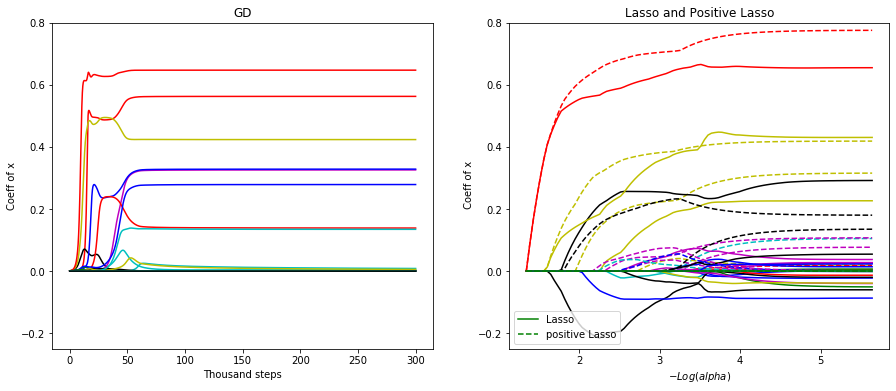

In [11]:
# (v) full lasso path [2]
print(__doc__)

from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import lasso_path, enet_path
from sklearn import datasets

# convert tensor to array
Anp = A.numpy()
xnp = x.numpy()
ynp = y.numpy().reshape(n) # reshape from (n,1) to (n)
print(ynp.shape)

# Compute paths

eps = 5e-5  # the smaller it is the longer is the path

print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(Anp, ynp, eps, fit_intercept=False)

# Compare with positive Lasso, since our GD model use x>0
print("Computing regularization path using the positive lasso...")
alphas_positive_lasso, coefs_positive_lasso, _ = lasso_path(
    Anp, ynp, eps, positive=True, fit_intercept=False)


# Display results

plt.figure(figsize = (15,6) )
colors = cycle(['b', 'r', 'g', 'c', 'k','m', 'y'])

plt.subplot(121)
for i, c in zip(range(m), colors):
  plt.plot((t_rec/1000),x_rec[i,:], c=c)
plt.xlabel('Thousand steps')
plt.ylabel('Coeff of x')
plt.ylim(-0.25,0.8)
plt.title('GD')

plt.subplot(122)
neg_log_alphas_lasso = -np.log10(alphas_lasso)
neg_log_alphas_positive_lasso = -np.log10(alphas_lasso)
for coef_l, coef_pl, c in zip(coefs_lasso, coefs_positive_lasso, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    l2 = plt.plot(neg_log_alphas_positive_lasso, coef_pl, linestyle='--', c=c)
plt.xlabel('$-Log(alpha)$')
plt.ylim(-0.25,0.8)
plt.ylabel(' Coeff of x')
plt.title('Lasso and Positive Lasso')
plt.legend((l1[-1], l2[-1]), ('Lasso', 'positive Lasso'), loc='lower left')
plt.show()




## Hw 3 Pb 2e)
### (v) Compare the result

I choose to compare the GD plot and __Positive__ Lasso plot since these two cases fix $\vec{x}$ to be positive. We notice that GD gives a sparsier result, which is better predict $\vec{x}^*$. Fortunately, when we decreases $\lim \lambda$ or $\epsilon$ to $0$ the predict $\vec{x}$ from Positive Lass converge the result from GD.


## Hw 3 Pb 2f)
Logic:

* 
* shuffle a small set of support $(i,j)\in \Omega$  
* initialize $U^T U$
